### **Importing Necessary Liberaries**

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image

### **Define Custom Dataset Class**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


## **Paths to the dataset and labels**

In [ ]:
root_dir = '/content/drive/MyDrive/DL/data/new_dataset'
csv_filename = '/content/drive/MyDrive/DL/data/dataset_labels.csv'

### **Transform**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### **Load the data and transform**

In [ ]:
dataset = CustomDataset(csv_file=csv_filename, root_dir=root_dir, transform=transform)
dataset

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [ ]:
print("Dataset size:", len(dataset))


Dataset size: 199


Sample label: 0


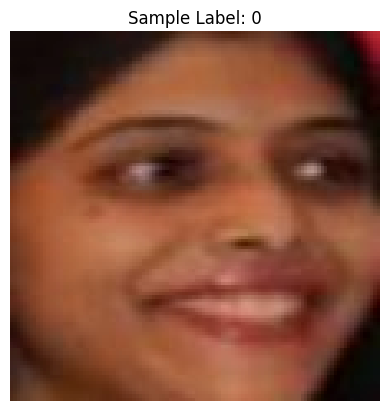

In [ ]:
sample_image, sample_label = dataset[0]
print("Sample label:", sample_label)

if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample_image = sample_image * torch.tensor(std) + torch.tensor(mean)
    sample_image = torch.clamp(sample_image, 0, 1)
    sample_image = sample_image.numpy()
    plt.imshow(sample_image)
    plt.title(f"Sample Label: {sample_label}")
    plt.axis('off')
    plt.show()


## **Train,Test and Validation split**

In [ ]:
train_val_split = int(len(dataset) * 0.9)
test_split = len(dataset) - train_val_split
train_val_dataset, test_dataset = random_split(dataset, [train_val_split, test_split])

In [ ]:
train_split = int(train_val_split * 0.88)
val_split = train_val_split - train_split
train_dataset, val_dataset = random_split(train_val_dataset, [train_split, val_split])

### **Create DataLoaders for train, test and validation split**

In [ ]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### **Model Loading**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter

In [ ]:
class Conv_block(nn.Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(nn.Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(nn.Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(nn.Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)


In [ ]:
class MobileFaceNet(nn.Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)


In [ ]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

In [ ]:
model_weights = torch.load("/content/drive/MyDrive/DL/model_mobilefacenet.pth",
                           map_location=torch.device('cpu'))


In [ ]:
model = MobileFaceNet(embedding_size=512)

In [ ]:
model.load_state_dict(model_weights)

<All keys matched successfully>

### **Model Training**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
num_classes=10

In [ ]:
in_features = model.linear.in_features
new_linear_layer = nn.Linear(in_features, num_classes)
model.linear = new_linear_layer

In [ ]:
new_bn_layer = nn.BatchNorm1d(num_classes)
model.bn = new_bn_layer

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

## **Training Loop**

In [ ]:
num_epochs=10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print(labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {total_loss / len(train_loader):.4f}, '
          f'Training Accuracy: {(100 * correct / total):.2f}%')


Epoch 1/10, Training Loss: 2.2462, Training Accuracy: 14.65%
Epoch 2/10, Training Loss: 1.9155, Training Accuracy: 57.96%
Epoch 3/10, Training Loss: 1.8299, Training Accuracy: 70.70%
Epoch 4/10, Training Loss: 1.7643, Training Accuracy: 83.44%
Epoch 5/10, Training Loss: 1.7411, Training Accuracy: 82.80%
Epoch 6/10, Training Loss: 1.7562, Training Accuracy: 79.62%
Epoch 7/10, Training Loss: 1.7583, Training Accuracy: 80.89%
Epoch 8/10, Training Loss: 1.7203, Training Accuracy: 84.08%
Epoch 9/10, Training Loss: 1.7014, Training Accuracy: 82.80%
Epoch 10/10, Training Loss: 1.7017, Training Accuracy: 84.08%


### **Saving the trained Model**

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DL/fine_tuned_mobilefacenet.pth')
print("Fine-tuning completed.")

Fine-tuning completed.


## **Evaluate the Model**

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
average_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total


In [ ]:
print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Test Loss: 2.0997
Test Accuracy: 35.00%


### **HyperParameter Tuning from Validation set**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
momentums = [0.9, 0.95, 0.99]

In [ ]:
best_lr = None
best_momentum = None
best_validation_loss = float('inf')

In [ ]:
for lr in learning_rates:
    for momentum in momentums:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                validation_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                best_lr = lr
                best_momentum = momentum
print(f'Best Learning Rate: {best_lr}')
print(f'Best Momentum: {best_momentum}')


Best Learning Rate: 0.01
Best Momentum: 0.95


## **Retrain the Model with Best Hyperparameters**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {total_loss / len(train_loader):.4f}, '
          f'Training Accuracy: {(100 * correct / total):.2f}%')


Epoch 1/10, Training Loss: 1.6918, Training Accuracy: 85.35%
Epoch 2/10, Training Loss: 1.7058, Training Accuracy: 84.08%
Epoch 3/10, Training Loss: 1.6762, Training Accuracy: 87.26%
Epoch 4/10, Training Loss: 1.7082, Training Accuracy: 80.89%
Epoch 5/10, Training Loss: 1.7196, Training Accuracy: 79.62%
Epoch 6/10, Training Loss: 1.7109, Training Accuracy: 81.53%
Epoch 7/10, Training Loss: 1.7203, Training Accuracy: 78.34%
Epoch 8/10, Training Loss: 1.6999, Training Accuracy: 82.17%
Epoch 9/10, Training Loss: 1.6817, Training Accuracy: 84.08%
Epoch 10/10, Training Loss: 1.6794, Training Accuracy: 84.08%


### **Save the final Model**

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DL/final_fine_tuned_mobilefacenet.pth')
print("Fine-tuning completed.")

Fine-tuning completed.


### **Evaluate with the final model**

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
average_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total


In [ ]:
print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.234
Test Accuracy: 86.09%
